# Gradient methods for optimization in Machine learning

We test various optimization algorithms based on gradient methods (simple gradient, stochastic gradient, Nesterov accelerated gradient, Adam). In the first part of this notebook, we consider a simple two dimensional loss function $L(X)$ and try to minimize it with respect to the 2-dimensional variable $X$. In the second part of the notebook, we turn to the minimization of some training loss in the context of nonlinear regression. In this setting, the variable to be optimized is $\theta$ and $X$ denotes training or test data.

In both cases, you should play with the timestep/learning rate (denoted by $\eta$ in this notebook) in order to have some efficient optimization.

**There are 6 questions to answer. Part 2 on minibatching is optional.**

In [1]:
#----- for scientific computing parts ------
import numpy as np
import math 
#---- for plots ------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Part 1 - Optimizing two dimensional potentials

### Defining potential energy functions and forces

We use the Müller-Brown potential, considered in various works in physics, for instance https://pubs.acs.org/doi/full/10.1021/acs.jctc.2c00314

$$
V(x,y) = \sum_{k=1}^4 A_k exp[a_k (x - x1ref_k)^2 + b_k (x - x1ref_k)(y - x2ref_k) + c_k (y - x2ref_k)^2]
$$

In [2]:
class MullerBrown:

    A = [-200.,-100.,-170.,15.]
    a = [-1.,-1.,-6.5,0.7]
    b = [0.,0,11.,0.6]
    c = [-10.,-10.,-6.5,0.7]
    x1ref = [1.,0,-0.5,-1.]
    x2ref = [0.,0.5,1.5,1.]
    
    #--- potential energy function ---    
    def L(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate
        :return: float, value of the potential at x 
        """
        assert(type(x) == np.ndarray)
        assert(x.ndim == 2)
        assert(x.shape[1] == 2)
        val = 0.
        for i in range(0,len(self.A)):
            arg = self.a[i]*(x[:,0]-self.x1ref[i])**2 
            arg += self.b[i]*(x[:,0]-self.x1ref[i])*(x[:,1]-self.x2ref[i]) 
            arg += self.c[i]*(x[:,1]-self.x2ref[i])**2
            val += self.A[i]*np.exp(arg)
        
        return val 
    
    #--- partial derivative with respect to x ---
    def dL_1(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate
        :return: val: float, derivative of the loss with respect to x
        """ 
        val = 0.
        for i in range(0,len(self.A)):
            arg = self.a[i]*(x[:,0]-self.x1ref[i])**2 
            arg += self.b[i]*(x[:,0]-self.x1ref[i])*(x[:,1]-self.x2ref[i]) 
            arg += self.c[i]*(x[:,1]-self.x2ref[i])**2
            deriv = 2*self.a[i]*(x[:,0]-self.x1ref[i]) + self.b[i]*(x[:,1]-self.x2ref[i]) 
            val += deriv*self.A[i]*np.exp(arg)
        
        return val
    
    #--- partial derivative with respect to y ---
    def dL_2(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate

        :return: val: float, derivative of the loss with respect to y
        """ 
        val = 0.
        for i in range(0,len(self.A)):
            arg = self.a[i]*(x[:,0]-self.x1ref[i])**2 
            arg += self.b[i]*(x[:,0]-self.x1ref[i])*(x[:,1]-self.x2ref[i]) 
            arg += self.c[i]*(x[:,1]-self.x2ref[i])**2
            deriv = self.b[i]*(x[:,0]-self.x1ref[i]) + 2*self.c[i]*(x[:,1]-self.x2ref[i])
            val += deriv*self.A[i]*np.exp(arg)
        
        return val
    
    #--- gradient of the loss ---
    def nabla_L(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate
        :return: np.array, array of gradients with respect to position vector, ndim = 2, shape = (,2)
        """
        assert(type(x) == np.ndarray)
        assert(x.ndim == 2)
        assert(x.shape[1] == 2)
        return np.column_stack( (self.dL_1(x), self.dL_2(x)) )

We first check that partial derivatives have been correctly computed, by comparing the analytical formula to a second order approximation based on a centered finite difference. We do this for 3 points at the same time, to demonstrate that operations have been vectorized.

In [3]:
loss = MullerBrown()
X = np.random.rand(3,2) # 3 two dimensional points at random
sigma = 10**(-4)
deltaX1 = np.array([sigma,0])
deltaX2 = np.array([0,sigma])
print("Evaluation at X = ",X)
print("\nValues of the loss =",loss.L(X))
print("\nPartial derivatives in direction 1 = ",loss.dL_1(X))
print("Finite diff. approximations dir. 1 = ",(loss.L(X+deltaX1)-loss.L(X-deltaX1))/(2*sigma))
print("\nPartial derivatives in direction 2 = ",loss.dL_2(X))
print("Finite diff. approximations dir. 2 = ",(loss.L(X+deltaX2)-loss.L(X-deltaX2))/(2*sigma))
print("\nGradients = ",loss.nabla_L(X))

Evaluation at X =  [[0.74942197 0.44757633]
 [0.84270009 0.23661281]
 [0.21450475 0.5070544 ]]

Values of the loss = [  7.7825376  -31.56579674 -68.84212456]

Partial derivatives in direction 1 =  [258.09562557 227.98089132  76.95764732]
Finite diff. approximations dir. 1 =  [258.09562789 227.98089466  76.9576475 ]

Partial derivatives in direction 2 =  [193.11453304 401.93817963  98.48152695]
Finite diff. approximations dir. 2 =  [193.11454653 401.93815355  98.48153158]

Gradients =  [[258.09562557 193.11453304]
 [227.98089132 401.93817963]
 [ 76.95764732  98.48152695]]


We plot the loss function to have a look at it.

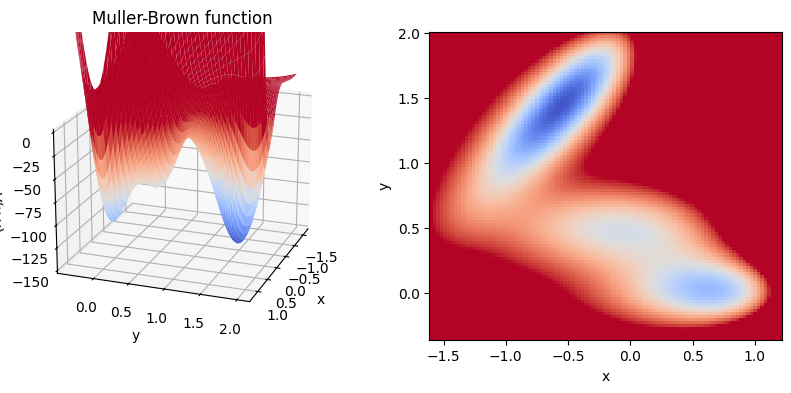

In [4]:
loss = MullerBrown()
# x and y domains for the plots
x_domain = [-1.6, 1.2] 
y_domain = [-0.35, 2] 
loss_min_max = [-150, 0] # bounds on values of the loss for plots 

gridx = np.linspace(x_domain[0], x_domain[1], 100)
gridy = np.linspace(y_domain[0], y_domain[1], 100)
x_plot = np.outer(gridx, np.ones(100)) 
y_plot = np.outer(gridy, np.ones(100)).T 
x2d = np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)
loss_on_grid = loss.L(x2d).reshape(100,100)

fig = plt.figure(figsize=(10,4))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)
ax0.set_title("Muller-Brown function")
#--- to fix angles // in colab, otherwise in notebook could rotate using the mouse/touchpad ---
ax0.view_init(elev=20, azim=20) # play on the angles here to change the visualization
ax0.plot_surface(x_plot, y_plot, loss_on_grid ,vmin=loss_min_max[0], vmax=loss_min_max[1], cmap='coolwarm', edgecolor='none')
ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_zlabel("V(x,y)")
ax0.set_zbound(loss_min_max[0], loss_min_max[1])
ax1.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
plt.show()

**Question 1.** What are the maximum and minimum values on the loss on this grid?

In [5]:
max_loss = np.max(loss_on_grid)
min_loss = np.min(loss_on_grid)

print("Max loss = ",max_loss, " at x = ",x2d[np.argmax(loss_on_grid),0],"and y = ",x2d[np.argmax(loss_on_grid),1])
print("Min loss = ",min_loss, " at x = ",x2d[np.argmin(loss_on_grid),0],"and y = ",x2d[np.argmin(loss_on_grid),1])

Max loss =  3347.7688981091933  at x =  1.2 and y =  2.0
Min loss =  -146.61058256066468  at x =  -0.5535353535353538 and y =  1.4540404040404042


### Simple gradient method

We start by running a simple gradient method as
$$
X^{n+1} = X^n - \eta \nabla L(X^n)
$$
This functions takes as argument a potential object, an initial condition, the number of simulation steps and a time step. It possibly records the value of the potential energy function at the points along the trajectory.initial

In [6]:
def SimpleGradient(loss, X_0, eta=1e-3, Nepochs=1000, seed=None):
    """Performs a simple gradient dynamics 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param eta: learning rate
    :param Nepochs: number of iterations 
   
    :return: traj and loss_values, which are both np.array
    """
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    traj = []
    loss_values = []
    for i in range(Nepochs):
        X = X - eta*loss.nabla_L(X.reshape(1,dim))
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

**Question 2.** Play with the learning rate $\eta$ to find a good value (large enough in order for the convergence not to be too slow, but not too large in order to prevent oscillations/non convergence). Check also what happens when starting from $X^0 =(0,0)$ instead of $X^0 = (-1,0.5)$.

YOUR ANSWERE HERE

In [7]:
# etas = [1e-5, 1e-4, 1e-3, 1e-2]  # List of learning rates to try
# Nepochs = 1000  # Number of epochs for each trial
# seed = None  # Seed for random number generation
# x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]

# best_eta = None
# best_loss = float('inf')

# for eta in etas:
#     trajectory, loss_values = SimpleGradient(loss, x_0, eta, Nepochs, seed)
#     final_loss = loss_values[-1]
    
#     if final_loss < best_loss:
#         best_loss = final_loss
#         best_eta = eta

# print("Best learning rate:", best_eta)

In [8]:
eta = 1e-4 # TO COMPLETE
Nepochs = 1000
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
# x_0 = np.array([0.,0.]) 
trajectory, loss_values = SimpleGradient(loss,x_0,eta,Nepochs,seed)

The trajectory can then be plotted over the loss landscape, to check whether it converges to some local minimum. The values of the loss function should also be monitored.

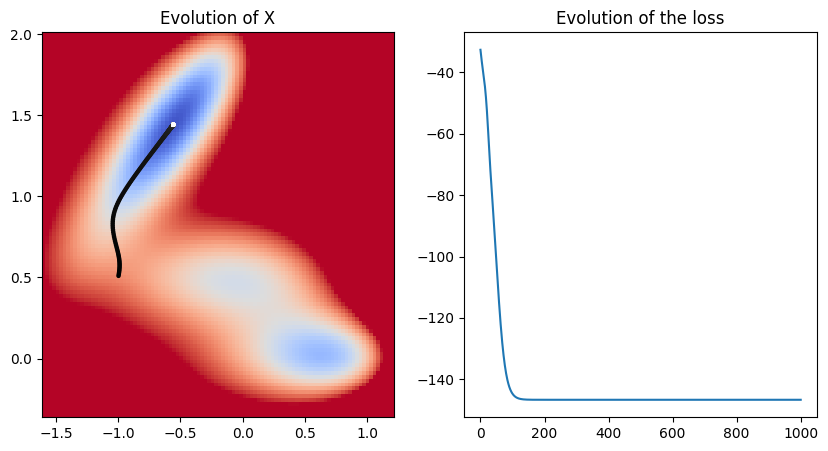

In [9]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

### Stochastic gradient dynamics

We now consider the situation when the gradient is not exactly computed, but we have an unbiased stochastic estimator of it. In order to emulate SGD, we add a random component to the force, with average 0. This leads to the dynamics
$$
X^{n+1} = X^n + \eta \left( -\nabla L(X^n) + \sigma G^n\right).
$$
The magnitude $\sigma$ is fixed here, but it depends in practical situations on the minibatching size.

In [10]:
def SGD(loss, X_0, eta, Nepochs, sigma, seed=None):
    """Performs stochastic gradient dynamics in an ideal setting 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param eta: learning rate
    :param Nepochs: number of iterations 
    :param sigma: magnitude of the minibatching noise
   
    :return: traj and loss_values, which are both np.array
    """
    r = np.random.RandomState(seed)
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    traj = []
    loss_values = []
    for i in range(Nepochs):
        # we emulate the noise in the computation of the force 
        force = -loss.nabla_L(X.reshape(1,dim)) + sigma*r.normal(size=(dim,))
        X = X + eta*force
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

**Question 3.** Compare the behavior of SGD to simple gradient dynamics depending on the magnitude of $\sigma$. 

We can observe that with the same learning rate, the SGD leads to an evolution of the loss that is less smooth (with oscillations) compared to the results obtained with the simple gradient dynamics.

In [11]:
eta = 1e-4 # TO COMPLETE
sigma = 200
Nepochs = 1000
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
trajectory, loss_values = SGD(loss,x_0,eta,Nepochs,sigma,seed)

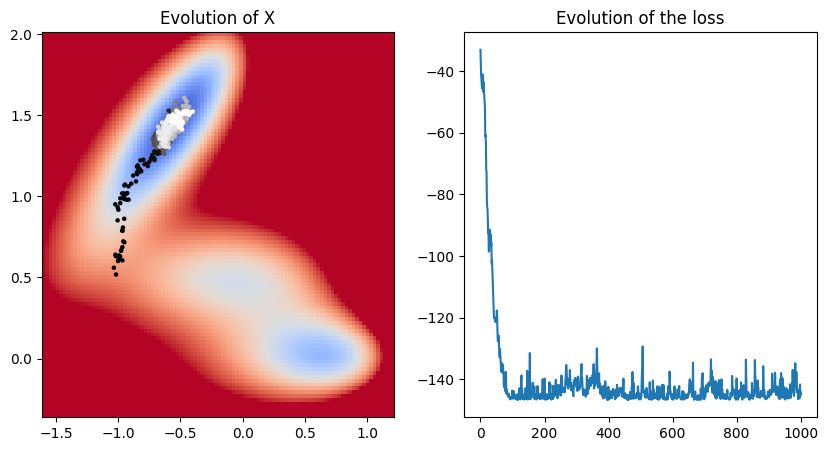

In [12]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

## Nesterov accelerated gradient

Using some inertia in the minimization procedure may be beneficial. Here, this means adding a momentum variable $V$ to the position variable $X$.

**Question 4.** Implement the Nesterov accelerated gradient method seen in class, and find a relevant value of $\beta$. 

In [13]:
def Nesterov(loss, X_0, eta, beta, Nepochs, sigma, seed=None):
    """Performs Nesterov gradient descent in an ideal minibatching setting 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param V_0: initial momentum
    :param eta: learning rate
    :param beta: refreshment parameter
    :param Nepochs: number of iterations 
    :param sigma: magnitude of the minibatching noise
   
    :return: traj and loss_values, which are both np.array
    """
    r = np.random.RandomState(seed)
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    V = np.zeros((1,dim))
    traj = []
    loss_values = []
    for i in range(Nepochs):
        #--- Nesterov accelerated gradient ---
        Y = X + beta*V # TO COMPLETE
        # we emulate the noise in the computation of the force 
        force = -loss.nabla_L(Y) + sigma*r.normal(size=(dim,))
        V = beta*V + eta*force # TO COMPLETE
        X = X - eta*V # TO COMPLETE
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

We can then run the dynamics.

In [14]:
eta = 1e-4 # TO COMPLETE
beta = 0.999
sigma = 200
Nepochs = 300
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
# x_0 = np.array([0.,0.])
trajectory, loss_values = Nesterov(loss,x_0,eta,beta,Nepochs,sigma,seed)

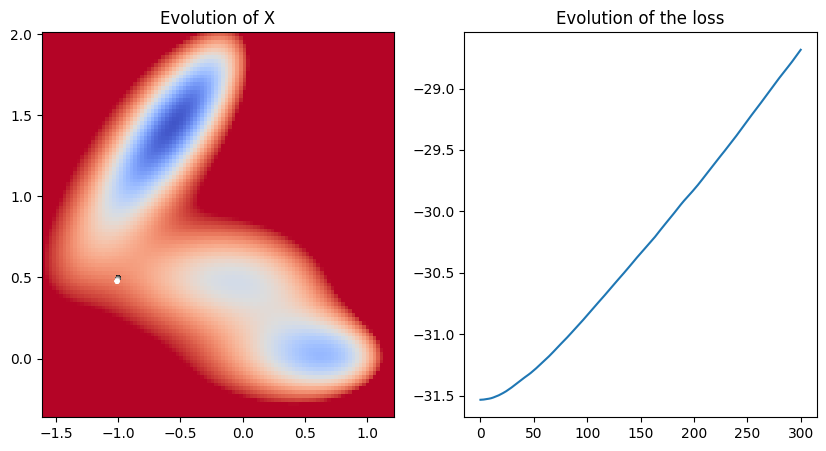

In [15]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

### ADAM

We next consider the Adam algorithm presented in https://arxiv.org/abs/1412.6980.

**Question 5.** Implement the Adam method, and run it with the default suggested parameters $\beta_1,\beta_2$. How does the method compare to SGD?

In [16]:
def Adam(loss, X_0, eta, beta1, beta2, Nepochs, sigma, eps, seed=None):
    """Performs Adam in an ideal setting 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param eta: learning rate
    :param Nepochs: number of iterations 
    :param sigma: magnitude of the minibatching noise
   
    :return: traj and loss_values, which are both np.array
    """
    r = np.random.RandomState(seed)
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    v = np.zeros((1,dim)) # weighted averages of forces
    s = np.zeros((1,dim)) # weighted averages of second moment of forces
    traj = []
    loss_values = []
    for i in range(Nepochs):
        force = -loss.nabla_L(X.reshape(1,dim)) + sigma*r.normal(size=(dim,))
        v = beta1*v + (1-beta1)*force
        s = beta2*s + (1-beta2)*force**2
        v_hat = v/(1-beta1**(i+1))
        s_hat = s/(1-beta2**(i+1))
        X = X - eta*v_hat/(np.sqrt(s_hat)+eps)
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

We can then run the dynamics.

In [17]:
eta = 1e-4 # TO COMPLETE
beta1 = 0.9
beta2 = 0.999
eps = 10**(-6)
sigma = 200
Nepochs = 1000
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
trajectory, loss_values = Adam(loss,x_0,eta,beta1,beta2,Nepochs,sigma,eps,seed)

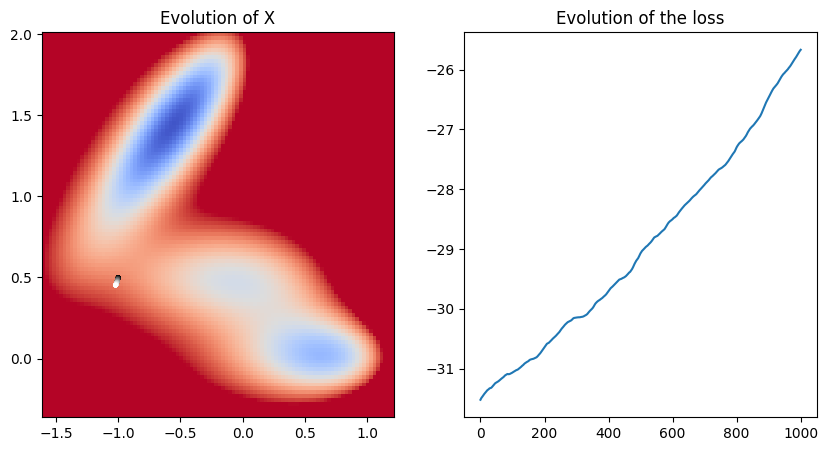

In [18]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

We can notice that the evolution of the loss is more "linear" (smooth) than the one obtained with the SGD.

## Part 2 - Training with actual minibatching noise (optional)

We now use gradient methods to train a simple (nonlinear) regression model. We consider a synthetic dataset of points $x_i \in \mathbb{R}$ and associated values
$$
y_i = f_\theta(x_i) = \frac{1}{1+\exp(-\theta_1 x_i - \theta_2)} + \varepsilon_i, \qquad \varepsilon_i \sim \mathcal{N}(0,\sigma^2). 
$$
Given the dataset $\{ (x_i,y_i) \}_{1 \leq i \leq N_\text{data}}$, the aim is to predict the value $y$ obtained at a new point $x$. This is done by finding the parameter $\theta = (\theta_1,\theta_2,\theta_3)$ which minimizes the loss function
$$
L_\lambda(\theta) = \frac1{N_\text{data}} \sum_{i=1}^{N_\text{data}} |y_i - f_\theta(x_i)|^2 + \lambda |\theta|^\alpha,
$$
with $\alpha=2$ (ridge regression) or $\alpha=1$ (LASSO). We will not consider regularization terms here, though.

We start by creating the dataset, and separating it into a set of $N_\text{train}$ data points for the training set, and $N_\text{test}$ data points for the test set.

In [19]:
def function(x):
    return 1/(1+np.exp(-x))

def derivative_function(x):
    return np.exp(-x)/(1+np.exp(-x))**2

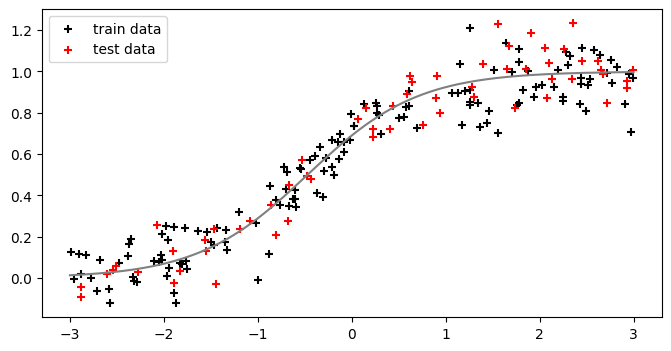

In [20]:
#------ generation of the full synthetic dataset ------
Ndata = 200
true_theta_1 = 1.7
true_theta_2 = 0.8
L = 3
noise = 0.1
X = np.random.uniform(-L,L,Ndata)
Y = function(true_theta_1*X+true_theta_2)+noise*np.random.standard_normal(Ndata)

#----- we separate the data between training and test (manually, here) -----
ratio = 0.7
N_train = round(ratio*Ndata)
X_train = X[0:N_train]
Y_train = Y[0:N_train]
X_test = X[N_train:Ndata]
Y_test = Y[N_train:Ndata]

#----- plot the dataset -------
x_grid = np.linspace(-L,L,1000)
y_grid = function(true_theta_1*x_grid+true_theta_2)
plt.figure(figsize=(8,4))
plt.plot(x_grid,y_grid,color='grey')
plt.scatter(X_train,Y_train,marker='+',color='black',label='train data')
plt.scatter(X_test,Y_test,marker='+',color='red',label='test data')
plt.legend()
plt.show()

We start by defining the loss function.

In [21]:
def Loss(theta,X,Y):
    Z = Y-function(theta[0]*X+theta[1])
    return np.mean(Z**2)

We can plot it on a grid to visualize it.

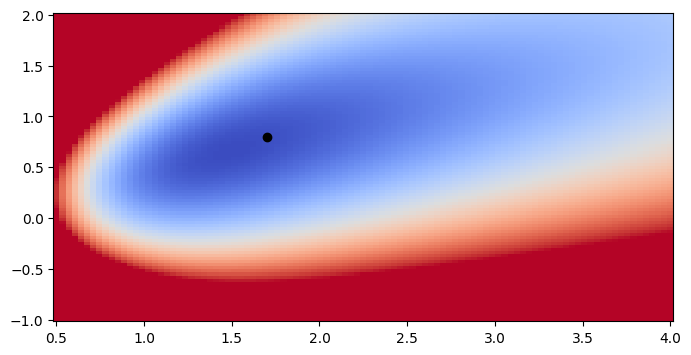

In [22]:
theta1_grid_min = 0.5
theta1_grid_max = 4.
theta2_grid_min = -1.
theta2_grid_max = 2.
Ntheta_grid = 101
theta1_grid = np.linspace(theta1_grid_min,theta1_grid_max,Ntheta_grid)
theta2_grid = np.linspace(theta2_grid_min,theta2_grid_max,Ntheta_grid)
loss_on_grid = np.zeros((Ntheta_grid,Ntheta_grid))
theta1_2d_grid = np.zeros((Ntheta_grid,Ntheta_grid))
theta2_2d_grid = np.zeros((Ntheta_grid,Ntheta_grid))
for i in range(Ntheta_grid):
    for j in range(Ntheta_grid):
        loss_on_grid[i,j] = Loss([theta1_grid[i],theta2_grid[j]],X_train,Y_train)
        theta1_2d_grid[i,j] = theta1_grid[i]
        theta2_2d_grid[i,j] = theta2_grid[j]

plt.figure(figsize=(8,4))
plt.pcolormesh(theta1_2d_grid,theta2_2d_grid,loss_on_grid,cmap='coolwarm',shading='auto',vmax=4*loss_on_grid.min())
plt.scatter(true_theta_1,true_theta_2,marker='o',color='black')
plt.show()

Minibatching is implemented by randomly sampling data points in order to estimate the opposite of the gradient. This can be done for instance by generating a random set $I_m \subset [1,N_\text{train}]$ of size $m$ (without replacement), and then evaluating the following estimator for a given value of $\theta = (\theta_1,\theta_2)$ when $\lambda =0$:
$$
\widehat{F}_m(\theta) = \frac{2}{m} \sum_{j \in I_m} (Y_i - f_\theta(X_i)) f_\theta'(X_i)\begin{pmatrix} X_i \\ 1 \end{pmatrix}.
$$
Note that $F_{N_\text{data}} = -\nabla L_0(\theta)$. When a regularization term is considered, it suffices to add the gradient of the regularization to the estimate of the gradient of the loss computed for $\lambda = 0$.

In [23]:
def MinibatchingForce(theta,minibatch_size,X,Y):
    dim = X.shape[0] 
    #-- finding the indices of the points to retain --
    Z = np.array([X_train.T,Y_train.T]).T
    minibatch_indices = np.random.choice(np.arange(0,dim),minibatch_size,replace=False)
    #-- keeping only the corresponding data points --
    Y_mb = Y[minibatch_indices]
    X_mb = X[minibatch_indices]
    XX = np.ones((2,minibatch_size))
    XX[0,:] = X_mb
    #-- computing the estimated gradient --
    F = 2/minibatch_size*np.sum( (Y_mb-function(theta[0]*X_mb+theta[1]))*
                                derivative_function(theta[0]*X_mb+theta[1])*XX,axis=1)
    return F

**Question 6.** Check that the force computed when providing the full dataset is the true gradient of the loss. This can be checked by a finite difference approximation, which also allows to check the correctness of the formulas for the gradient of the loss.

In [24]:
epsilon = 1e-6

def compute_gradient(theta, X, Y):
    dim = len(theta)
    gradient = np.zeros(dim)
    for i in range(dim):
        theta_plus = theta.copy()
        theta_plus[i] += epsilon
        theta_minus = theta.copy()
        theta_minus[i] -= epsilon
        loss_plus = Loss(theta_plus, X, Y)
        loss_minus = Loss(theta_minus, X, Y)
        gradient[i] = (loss_plus - loss_minus) / (2 * epsilon)
    return gradient

# Compute the true gradient using the full dataset
true_gradient = compute_gradient([true_theta_1, true_theta_2], X_train, Y_train)

# Compute the estimated gradient using minibatching
estimated_gradient = -MinibatchingForce([true_theta_1, true_theta_2], len(X_train), X_train, Y_train)

# Compare the true gradient and the estimated gradient
print("True Gradient:", true_gradient)
print("Estimated Gradient:", estimated_gradient)


True Gradient: [0.00173425 0.00136346]
Estimated Gradient: [0.00173425 0.00136346]


We next look the statistics of the estimator of the gradient of the loss (without regularization term).

**Question 7.** What should the minibatch size be in order for the estimator to be approximately Gaussian?

Computation for theta =  [0.73166137 1.84974301]
Exact gradient:  [ 0.15690757 -0.09615919]


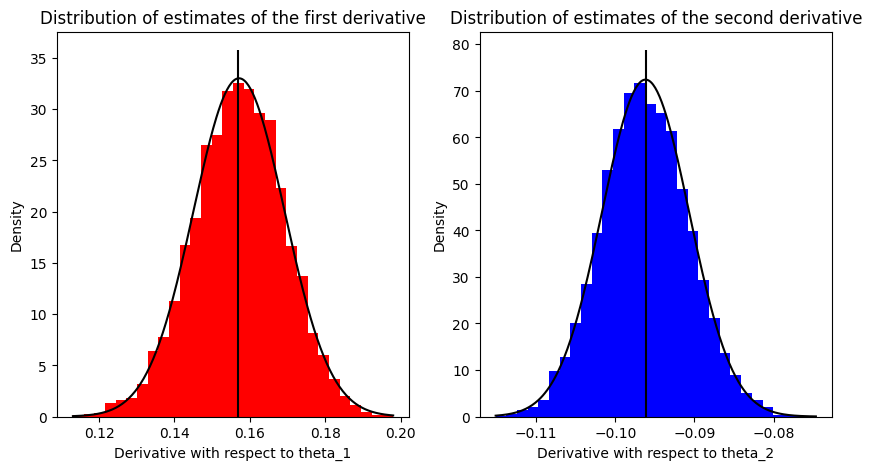

In [25]:
mb_size = 100 # TO COMPLETE // size of the minibatch (must be lower than N_train here) N_train=140
N_mb = 10000  # number of realization of the minibatching procedure
n_bins = 30  # number of bins for histograms

#-- random choice of the parameter --
theta_test = np.zeros(2)
theta_test[0] = np.random.uniform(theta1_grid_min,theta1_grid_max)
theta_test[1] = np.random.uniform(theta2_grid_min,theta2_grid_max)
print("Computation for theta = ",theta_test)
exact_gradient = MinibatchingForce(theta_test,N_train,X_train,Y_train)
print("Exact gradient: ",exact_gradient)

#-- performing N_mb realizations of the minibatching estimate --
gradient_estimator = np.zeros((N_mb,2))
for i in range(N_mb):
  gradient_estimator[i,:] = MinibatchingForce(theta_test,mb_size,X_train,Y_train)

#-- plotting the histograms of the distribution of the coordinates of the estimated gradient --
plt.figure(figsize=(10, 5))
#-- first coordinate of the gradient --
plt.subplot(1, 2, 1)
val, pos, _ = plt.hist(gradient_estimator[:,0],bins=n_bins,color='red',density=True)
plt.xlabel("Derivative with respect to theta_1")
plt.ylabel("Density")
plt.title('Distribution of estimates of the first derivative')
# reference value as a vertical bar
plt.vlines(exact_gradient[0],0,1.1*max(val),color='black')
# Gaussian approximation
pos_gauss = np.linspace(min(pos),max(pos),n_bins*10)
mu2 = np.mean(gradient_estimator[:,0])
std2 = np.std(gradient_estimator[:,0])
plt.plot(pos_gauss,np.exp(-(pos_gauss-mu2)**2/(2*std2**2))/np.sqrt(2*math.pi)/std2,color='black')
#-- same procedure for the second coordinate of the gradient --
plt.subplot(1, 2, 2)
val, pos, _ = plt.hist(gradient_estimator[:,1],bins=n_bins,color='blue',density=True)
plt.xlabel("Derivative with respect to theta_2")
plt.ylabel("Density")
plt.title('Distribution of estimates of the second derivative')
plt.vlines(exact_gradient[1],0,1.1*max(val),color='black')
pos_gauss = np.linspace(min(pos),max(pos),n_bins*10)
mu2 = np.mean(gradient_estimator[:,1])
std2 = np.std(gradient_estimator[:,1])
plt.plot(pos_gauss,np.exp(-(pos_gauss-mu2)**2/(2*std2**2))/np.sqrt(2*math.pi)/std2,color='black')
plt.show()

**Question 8.** Compare the performances of SGD and Adam.

Adam is better.

In [26]:
def SGD(theta_init, eta, mb_size, Nepochs, X, Y, seed=None):
    r = np.random.RandomState(seed)
    theta = theta_init
    traj = []
    loss_values = []
    for i in range(Nepochs):
        force = MinibatchingForce(theta,mb_size,X,Y)
        theta = theta + eta*force
        traj.append(theta)
        loss_values.append(Loss(theta,X,Y))
            
    return np.array(traj), np.array(loss_values)

In [27]:
def Adam(theta_init, eta, mb_size, Nepochs, beta1, beta2, eps, X, Y, seed=None):
    r = np.random.RandomState(seed)
    theta = theta_init
    m = np.zeros(2)
    s = np.zeros(2)
    traj = []
    loss_values = []
    for i in range(Nepochs):
        force = MinibatchingForce(theta,mb_size,X,Y)
        m = beta1*m + (1-beta1)*force
        s = beta2*s + (1-beta2)*force**2
        mh = m/(1-beta1**(i+1))
        sh = s/(1-beta2**(i+1))
        theta = theta + eta*mh*(np.sqrt(sh)+eps)**(-1)
        traj.append(theta)
        loss_values.append(Loss(theta,X,Y))
            
    return np.array(traj), np.array(loss_values)

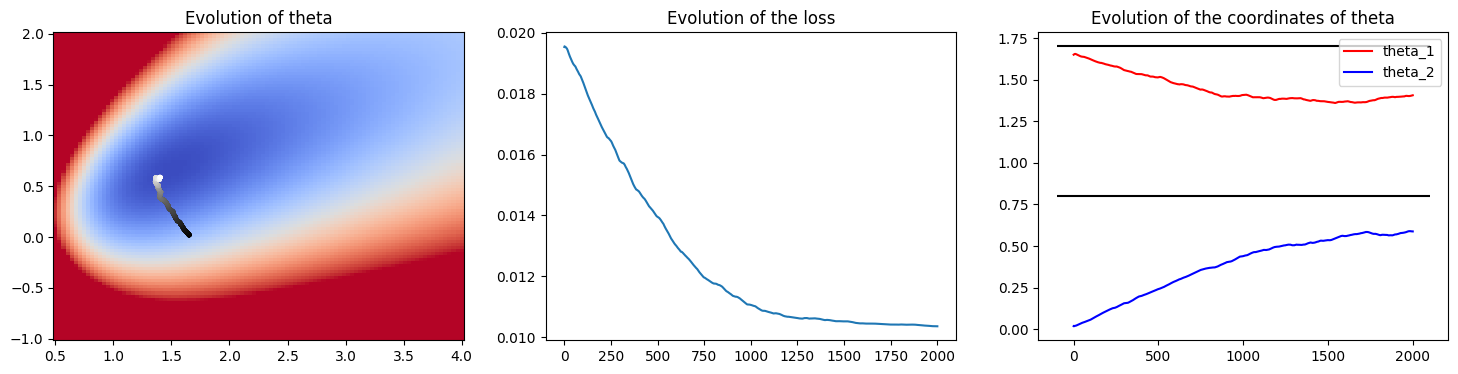

In [33]:
# parameters for optimization run
eta = 1e-3 # TO COMPLETE
m = 1  # Minibatch size
Nepochs = 2000
# for ADAM
beta1 = 0.9
beta2 = 0.999
eps = 10**(-6)

# start from random parameters
theta_init = np.zeros(2)
theta_init[0] = np.random.uniform(theta1_grid_min,theta1_grid_max)
theta_init[1] = np.random.uniform(theta2_grid_min,theta2_grid_max)

# perform SGD or Adam --> uncomment to choose here
# trajectory, loss_val = SGD(theta_init,eta,m,Nepochs,X_train,Y_train)
trajectory, loss_val = Adam(theta_init,eta,m,Nepochs,beta1,beta1,eps,X_train,Y_train)

# plot the result
fig = plt.figure(figsize=(18,4))
ax0 = fig.add_subplot(1, 3, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(theta1_2d_grid,theta2_2d_grid,loss_on_grid,cmap='coolwarm',shading='auto',vmax=4*loss_on_grid.min())
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of theta')
ax1 = fig.add_subplot(1, 3, 2)
ax1.plot(np.linspace(0,len(loss_val),len(loss_val)),loss_val)
ax1.set_title('Evolution of the loss')
ax2 = fig.add_subplot(1, 3, 3)
ax2.plot(np.linspace(0,len(loss_val),len(loss_val)),trajectory[:,0],color='red',label='theta_1')
ax2.plot(np.linspace(0,len(loss_val),len(loss_val)),trajectory[:,1],color='blue',label='theta_2')
ax2.set_title('Evolution of the coordinates of theta')
plt.legend()
ax2.hlines(true_theta_1,-.05*len(trajectory),1.05*len(trajectory),color='black')
ax2.hlines(true_theta_2,-.05*len(trajectory),1.05*len(trajectory),color='black')
plt.show()